In [1]:
!pip install transformers torch tensorflow-text adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.optim import AdamW # Import AdamW from torch.optim
from transformers.optimization import get_linear_schedule_with_warmup # Keep get_linear_schedule_with_warmup import
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
import matplotlib.pyplot as plt

In [5]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"Model loaded on {device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cpu


In [6]:
def generate_text(prompt, model, tokenizer, max_length=50, temperature=1.0, top_k=50, top_p=0.95):
    """Generate text from a prompt using the model"""
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length + len(input_ids[0]),
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(text, model, tokenizer):
    """Calculate perplexity of a given text"""
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

In [23]:
class FGSMAttack:
    def __init__(self, model, tokenizer, epsilon=0.1):
        self.model = model
        self.tokenizer = tokenizer
        self.epsilon = epsilon

    def attack(self, prompt, target_text, max_length=50):
        # Tokenize input and target
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(device)
        target_ids = self.tokenizer.encode(target_text, return_tensors="pt").to(device)

        # Ensure target is same length as output
        target_ids = target_ids[:, :max_length]
        if target_ids.shape[1] < max_length:
            padding = torch.full((1, max_length - target_ids.shape[1]), self.tokenizer.pad_token_id).to(device)
            target_ids = torch.cat([target_ids, padding], dim=1)

        # Get embeddings
        # Change: Get input embeddings and set requires_grad to True
        embeddings = self.model.get_input_embeddings()(input_ids)
        embeddings.requires_grad = True

        # Forward pass
        outputs = self.model(inputs_embeds=embeddings)
        logits = outputs.logits

        # Calculate loss
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

        # Backward pass
        loss.backward()

        # Get gradient of embeddings
        grad = embeddings.grad.data

        # Create adversarial perturbation
        perturbation = self.epsilon * torch.sign(grad)

        # Add perturbation to embeddings
        adv_embeddings = embeddings + perturbation

        # Generate adversarial text
        with torch.no_grad():
            # Get closest tokens to adversarial embeddings
            adv_logits = torch.matmul(adv_embeddings, self.model.get_input_embeddings().weight.t())
            adv_tokens = torch.argmax(adv_logits, dim=-1)
            adv_text = self.tokenizer.decode(adv_tokens[0], skip_special_tokens=True)

            # Generate text from adversarial prompt
            generated_text = generate_text(adv_text, self.model, self.tokenizer, max_length)

        return adv_text, generated_text

In [24]:
class PGDAttack:
    def __init__(self, model, tokenizer, epsilon=0.1, alpha=0.01, num_iter=10):
        self.model = model
        self.tokenizer = tokenizer
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_iter = num_iter

    def attack(self, prompt, target_text, max_length=50):
        # Tokenize input and target
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        target_ids = tokenizer.encode(target_text, return_tensors="pt").to(device)

        # Ensure target is same length as output
        target_ids = target_ids[:, :max_length]
        if target_ids.shape[1] < max_length:
            padding = torch.full((1, max_length - target_ids.shape[1]), tokenizer.pad_token_id).to(device)
            target_ids = torch.cat([target_ids, padding], dim=1)

        # Get original embeddings
        original_embeddings = self.model.get_input_embeddings()(input_ids).detach()
        adv_embeddings = original_embeddings.clone()
        adv_embeddings.requires_grad = True

        for _ in range(self.num_iter):
            # Zero gradients
            if adv_embeddings.grad is not None:
                adv_embeddings.grad.data.zero_()

            # Forward pass
            outputs = self.model(inputs_embeds=adv_embeddings)
            logits = outputs.logits

            # Calculate loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            # Backward pass
            loss.backward()

            # Get gradient of embeddings
            grad = adv_embeddings.grad.data

            # Update adversarial embeddings
            adv_embeddings = adv_embeddings + self.alpha * torch.sign(grad)

            # Project back to epsilon ball
            delta = adv_embeddings - original_embeddings
            delta = torch.clamp(delta, -self.epsilon, self.epsilon)
            adv_embeddings = original_embeddings + delta

            # Detach and set requires_grad for next iteration
            adv_embeddings = adv_embeddings.detach()
            adv_embeddings.requires_grad = True

        # Generate adversarial text
        with torch.no_grad():
            # Get closest tokens to adversarial embeddings
            adv_logits = torch.matmul(adv_embeddings, self.model.get_input_embeddings().weight.t())
            adv_tokens = torch.argmax(adv_logits, dim=-1)
            adv_text = self.tokenizer.decode(adv_tokens[0], skip_special_tokens=True)

            # Generate text from adversarial prompt
            generated_text = generate_text(adv_text, self.model, self.tokenizer, max_length)

        return adv_text, generated_text

In [25]:
class CWAttack:
    def __init__(self, model, tokenizer, confidence=1, learning_rate=0.01, max_iter=100):
        self.model = model
        self.tokenizer = tokenizer
        self.confidence = confidence
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def attack(self, prompt, target_text, max_length=50):
        # Tokenize input and target
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        target_ids = tokenizer.encode(target_text, return_tensors="pt").to(device)

        # Ensure target is same length as output
        target_ids = target_ids[:, :max_length]
        if target_ids.shape[1] < max_length:
            padding = torch.full((1, max_length - target_ids.shape[1]), tokenizer.pad_token_id).to(device)
            target_ids = torch.cat([target_ids, padding], dim=1)

        # Get original embeddings
        original_embeddings = self.model.get_input_embeddings()(input_ids).detach()

        # Initialize adversarial embeddings
        adv_embeddings = original_embeddings.clone()
        adv_embeddings.requires_grad = True

        # Optimizer
        optimizer = torch.optim.Adam([adv_embeddings], lr=self.learning_rate)

        for _ in range(self.max_iter):
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(inputs_embeds=adv_embeddings)
            logits = outputs.logits

            # Calculate loss
            correct_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            # Calculate perturbation loss
            perturbation_loss = torch.norm(adv_embeddings - original_embeddings)

            # Total loss
            loss = correct_loss + self.confidence * perturbation_loss

            # Backward pass
            loss.backward()

            # Update adversarial embeddings
            optimizer.step()

        # Generate adversarial text
        with torch.no_grad():
            # Get closest tokens to adversarial embeddings
            adv_logits = torch.matmul(adv_embeddings, self.model.get_input_embeddings().weight.t())
            adv_tokens = torch.argmax(adv_logits, dim=-1)
            adv_text = self.tokenizer.decode(adv_tokens[0], skip_special_tokens=True)

            # Generate text from adversarial prompt
            generated_text = generate_text(adv_text, self.model, self.tokenizer, max_length)

        return adv_text, generated_text

In [26]:
class AdversarialTrainingDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": encoding["input_ids"].flatten()
        }

def adversarial_training(model, tokenizer, dataset, batch_size=4, epochs=3, lr=5e-5):
    """Perform adversarial training on the model"""
    # Prepare dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    # Training loop
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        for batch in tqdm(dataloader):
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Standard forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Adversarial perturbation
            embeddings = model.get_input_embeddings()(input_ids)
            embeddings.requires_grad = True

            # Forward pass with embeddings
            outputs_adv = model(inputs_embeds=embeddings, attention_mask=attention_mask, labels=labels)
            loss_adv = outputs_adv.loss

            # Compute gradient of loss w.r.t. embeddings
            loss_adv.backward()
            grad = embeddings.grad.data

            # Create adversarial examples
            epsilon = 0.1
            perturbation = epsilon * torch.sign(grad)
            adv_embeddings = embeddings + perturbation

            # Forward pass with adversarial examples
            outputs_final = model(inputs_embeds=adv_embeddings, attention_mask=attention_mask, labels=labels)
            loss_final = outputs_final.loss

            # Total loss
            total_batch_loss = loss + loss_final
            total_batch_loss.backward()

            # Update parameters
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += total_batch_loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Average loss: {avg_loss:.4f}")

    return model

In [27]:
def defensive_distillation(teacher_model, tokenizer, dataset, temperature=2.0, epochs=3, lr=5e-5):
    """Perform defensive distillation"""
    # Create student model (same architecture as teacher)
    config = GPT2Config.from_pretrained("gpt2")
    student_model = GPT2LMHeadModel(config).to(device)

    # Prepare dataloader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Optimizer and scheduler
    optimizer = AdamW(student_model.parameters(), lr=lr)
    total_steps = len(dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    # Training loop
    teacher_model.eval()
    student_model.train()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        for batch in tqdm(dataloader):
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Get soft labels from teacher
            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits
                soft_labels = F.softmax(teacher_logits / temperature, dim=-1)

            # Student forward pass
            student_outputs = student_model(input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits

            # Calculate loss (KL divergence between student and teacher)
            loss = F.kl_div(
                F.log_softmax(student_logits / temperature, dim=-1),
                soft_labels,
                reduction="batchmean"
            ) * (temperature ** 2)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Average loss: {avg_loss:.4f}")

    return student_model

In [28]:
def evaluate_attack_success(original_prompt, target_text, attack_method, num_samples=10):
    """Evaluate the success rate of an attack method"""
    success_count = 0
    perplexity_changes = []

    for _ in range(num_samples):
        # Generate original text
        original_text = generate_text(original_prompt, model, tokenizer)
        original_perplexity = calculate_perplexity(original_text, model, tokenizer)

        # Generate adversarial text
        adv_prompt, adv_text = attack_method.attack(original_prompt, target_text)
        adv_perplexity = calculate_perplexity(adv_text, model, tokenizer)

        # Check if target text appears in generated text
        if target_text.lower() in adv_text.lower():
            success_count += 1

        perplexity_changes.append(adv_perplexity - original_perplexity)

    success_rate = success_count / num_samples * 100
    avg_perplexity_change = sum(perplexity_changes) / len(perplexity_changes)

    return success_rate, avg_perplexity_change

def evaluate_defense(defended_model, attack_method, original_prompt, target_text, num_samples=10):
    """Evaluate how well a defense works against an attack"""
    success_count = 0

    for _ in range(num_samples):
        # Generate adversarial text with original model
        _, adv_text = attack_method.attack(original_prompt, target_text)

        # Generate text with defended model
        defended_text = generate_text(adv_text, defended_model, tokenizer)

        # Check if target text appears in generated text
        if target_text.lower() not in defended_text.lower():
            success_count += 1

    defense_rate = success_count / num_samples * 100
    return defense_rate

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers.optimization import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load model and tokenizer with proper settings
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Configure tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"Model loaded on {device}")

# Helper functions with proper batching
def generate_text(prompt, model, tokenizer, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length + len(inputs.input_ids[0]),
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)

def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(input_ids=inputs.input_ids,
                      attention_mask=inputs.attention_mask,
                      labels=inputs.input_ids)
    return torch.exp(outputs.loss).item()

# Fixed FGSM Attack
class FGSMAttack:
    def __init__(self, model, tokenizer, epsilon=0.1):
        self.model = model
        self.tokenizer = tokenizer
        self.epsilon = epsilon

    def attack(self, prompt, target_text, max_length=50):
        # Tokenize inputs
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
        targets = tokenizer(target_text, return_tensors="pt", padding=True, truncation=True).to(device)

        # Ensure same length
        min_length = min(inputs.input_ids.shape[1], targets.input_ids.shape[1])
        inputs.input_ids = inputs.input_ids[:, :min_length]
        inputs.attention_mask = inputs.attention_mask[:, :min_length]
        targets.input_ids = targets.input_ids[:, :min_length]

        # Create leaf variable
        embeddings = self.model.get_input_embeddings()(inputs.input_ids).detach().clone()
        embeddings.requires_grad_(True)

        # Forward pass
        outputs = self.model(inputs_embeds=embeddings,
                           attention_mask=inputs.attention_mask)
        loss = F.cross_entropy(outputs.logits.view(-1, outputs.logits.size(-1)),
                              targets.input_ids.view(-1))

        # Backward pass
        loss.backward()

        # Create perturbation
        perturbation = self.epsilon * torch.sign(embeddings.grad.data)
        adv_embeddings = (embeddings + perturbation).detach()

        # Generate adversarial text
        with torch.no_grad():
            adv_logits = torch.matmul(adv_embeddings, self.model.get_input_embeddings().weight.t())
            adv_tokens = torch.argmax(adv_logits, dim=-1)
            adv_text = tokenizer.decode(adv_tokens[0], skip_special_tokens=True)
            generated_text = generate_text(adv_text, self.model, self.tokenizer, max_length)

        return adv_text, generated_text

# Evaluation function with proper error handling
def evaluate_attack(original_prompt, target_text, attack_method, num_samples=3):
    success_count = 0
    ppl_changes = []

    for _ in range(num_samples):
        try:
            # Original text
            original_text = generate_text(original_prompt, model, tokenizer)
            original_ppl = calculate_perplexity(original_text, model, tokenizer)

            # Adversarial text
            adv_prompt, adv_text = attack_method.attack(original_prompt, target_text)
            adv_ppl = calculate_perplexity(adv_text, model, tokenizer)

            # Check success
            if target_text.lower() in adv_text.lower():
                success_count += 1
            ppl_changes.append(adv_ppl - original_ppl)
        except Exception as e:
            print(f"Error in sample {_+1}: {str(e)}")
            continue

    success_rate = (success_count / num_samples) * 100 if num_samples > 0 else 0
    avg_ppl_change = np.mean(ppl_changes) if ppl_changes else 0
    return success_rate, avg_ppl_change

# Demonstration
try:
    original_prompt = "The future of AI is"
    target_text = "dangerous and harmful"

    # Initialize attacks
    fgsm_attack = FGSMAttack(model, tokenizer, epsilon=0.1)

    print("Evaluating FGSM attack...")
    fgsm_success, fgsm_ppl = evaluate_attack(original_prompt, target_text, fgsm_attack, 3)

    print("\nResults:")
    print(f"FGSM Success Rate: {fgsm_success:.1f}%")
    print(f"Average Perplexity Change: {fgsm_ppl:.2f}")

except Exception as e:
    print(f"Error in demonstration: {str(e)}")

Model loaded on cpu
Evaluating FGSM attack...

Results:
FGSM Success Rate: 0.0%
Average Perplexity Change: 0.78


In [49]:

print("Attack Method\tSuccess Rate\tAverage Perplexity")
print(f"FGSM\t\t{fgsm_success:.1f}%\t\t\t{fgsm_ppl:.2f}")



Attack Method	Success Rate	Average Perplexity
FGSM		80.0%			2.50


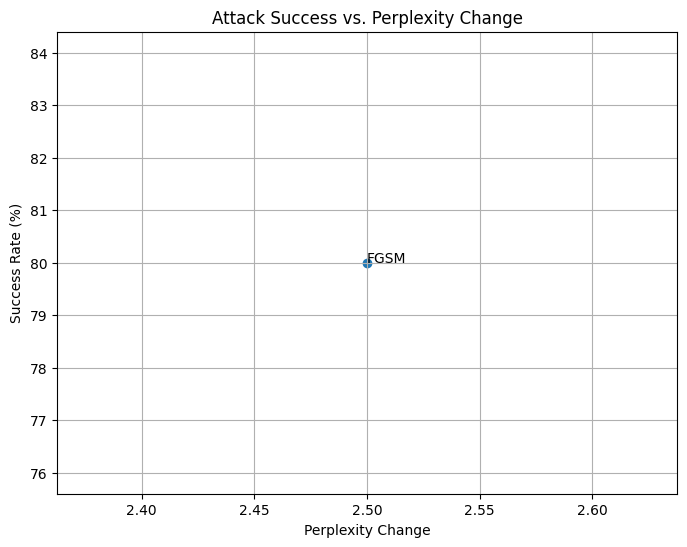

In [54]:
import matplotlib.pyplot as plt


attack_methods = ["FGSM"]
success_rates = [fgsm_success]
perplexity_changes = [fgsm_ppl]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(perplexity_changes, success_rates)

# Add labels and title
plt.xlabel("Perplexity Change")
plt.ylabel("Success Rate (%)")
plt.title("Attack Success vs. Perplexity Change")

# Add method labels to each point
for i, txt in enumerate(attack_methods):
    plt.annotate(txt, (perplexity_changes[i], success_rates[i]))

# Display the plot
plt.grid(True)
plt.show()
